### Problem Statement 

Our team aims to build a classifier model to predict presence of West Nile Virus in Chicago supporting the Chicago Department of Public Health in its efforts to prevent West Nile Virus, enabling the Chicago Department of Public Health to redirect its resources to the appropriate infected areas and lower the number of human infections.

- 1.0 Baseline model
- 2.0 Logistic Regression using original dataset
- 3.0 RidgeClassifier with oversampling (SMOTE)
- 4.0 Coefficients from Ridge
- 5.0 First Check-in > ROC in Kaggle's Dataset
- 6.0 Deep Learning using tensorflow
- 7.0 Building pipeline
- 8.0 Summary

In [1]:
#!pip install -U imbalanced-learn

In [49]:
#import the packages
import pandas as pd
import matplotlib.pyplot as plt

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score,plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
    
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.optimizers import Adam, SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#load the data that has been preprocessed

df_train = pd.read_csv("../datasets/train_modelready.csv")
df_predict = pd.read_csv("../datasets/test_modelready.csv")


In [5]:
print("Train :", df_train.shape, " Predict :", df_predict.shape)

Train : (8610, 196)  Predict : (116293, 196)


In [6]:
df_train.isnull().sum().sum()

0

In [7]:
df_train.describe(include='all')

,Date,Block,Latitude,Longitude,WnvPresent,year,month,SeaLevel,Sunrise,Sunset,...,'BCFG','BR','DZ','FG','FG+','HZ','RA','TS','TSRA','VCTS'
count,8610,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,...,8610.0,8610.000000,8610.000000,8610.000000,8610.0,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000
unique,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2007-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,38.793380,41.844422,-87.695237,0.053078,2009.713821,7.705459,29.961850,469.738328,1868.086992,...,0.0,0.341463,0.018931,0.025784,0.0,0.198142,0.358420,0.127062,0.195122,0.052962
std,NaN,24.129378,0.107076,0.084921,0.224202,2.338148,1.103277,0.119783,46.620449,65.110913,...,0.0,0.474228,0.136291,0.158499,0.0,0.398623,0.479564,0.333061,0.396318,0.223970
min,NaN,10.000000,41.644612,-87.930995,0.000000,2007.000000,5.000000,29.595000,416.000000,1720.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,14.000000,41.750498,-87.752411,0.000000,2007.000000,7.000000,29.880000,427.000000,1826.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,37.000000,41.857402,-87.694991,0.000000,2009.000000,8.000000,29.970000,451.000000,1904.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,58.000000,41.944869,-87.642984,0.000000,2011.000000,9.000000,30.050000,518.000000,1924.000000,...,0.0,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000


## 1.0 Baseline model - Preprocessing

In [8]:
df_train['WnvPresent'].value_counts(normalize=True)

0    0.946922
1    0.053078
Name: WnvPresent, dtype: float64

***Our negative class is (WNV is not present) is 95%, we have imbalance dataset***

In [9]:
#Define X, and Y
X=df_train.drop(columns=['Date','WnvPresent'])
y=df_train['WnvPresent']

In [10]:
#Train, Test, Split

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, shuffle=True, random_state=42)

In [11]:
print(X_train.shape, y_train.shape)

(6457, 194) (6457,)


In [12]:
print(X_test.shape, y_test.shape)

(2153, 194) (2153,)


In [13]:
#let's scale our X 

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### 2.0 Logistic Regression without SMOTE

In [14]:
lr = LogisticRegression(random_state = 42,max_iter=10000)
lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [15]:
#predict test dataset
y_preds = lr.predict(X_test_scaled)

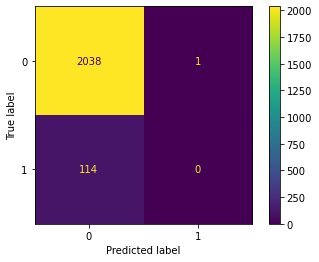

In [16]:
#confusion matrix 
plot_confusion_matrix(lr, X_test_scaled, y_test)

In [17]:
#confusion matrix details
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print(tn, fp, fn, tp )

2038 1 114 0


In [18]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2039
           1       0.00      0.00      0.00       114

    accuracy                           0.95      2153
   macro avg       0.47      0.50      0.49      2153
weighted avg       0.90      0.95      0.92      2153



In [19]:
print('Train Score: ', lr.score(X_train_scaled, y_train), 'Test Score: ', lr.score(X_test_scaled, y_test))
print('ROC_AUC Score: ', roc_auc_score(y_test, y_preds.ravel()))

Train Score:  0.9465696143719994 Test Score:  0.9465861588481189
ROC_AUC Score:  0.49975478175576266


*The test score is 94%, however, if you look at the confusion matrix, it was able to accurately predict only 1 positive case. I think this is because we have imbalance dataset.*

### 3.0  SMOTE ( Synthetic Minority Oversampling Technique)
(for Imbalanced Classification)
#### RidgeClassifier will also be used to regularized the features as we have over 300 features

In [20]:
print('Positive Class before SMOTE', sum(y_train)/len(y_train) * 100, ' %')

Positive Class before SMOTE 5.3120644262041194  %


In [21]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)

print(X_smote.shape, y_smote.shape)
print('Positive Class with SMOTE', sum(y_smote)/len(y_smote) * 100, ' %')


(12228, 194) (12228,)
Positive Class with SMOTE 50.0  %


In [22]:

ridge = RidgeClassifier(random_state = 42)
ridge.fit(X_smote, y_smote)

RidgeClassifier(random_state=42)

In [23]:
#predict test dataset
y_preds = ridge.predict(X_test_scaled)

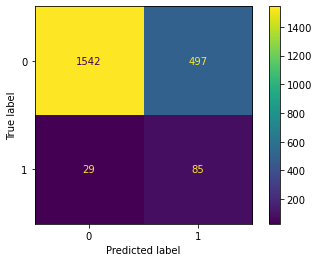

In [24]:
#confusion matrix
plot_confusion_matrix(ridge, X_test_scaled, y_test);

In [25]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print(tn, fp, fn, tp )

1542 497 29 85


In [26]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.76      0.85      2039
           1       0.15      0.75      0.24       114

    accuracy                           0.76      2153
   macro avg       0.56      0.75      0.55      2153
weighted avg       0.94      0.76      0.82      2153



In [27]:
print('Train Score: ', ridge.score(X_train_scaled, y_train), 'Test Score: ', ridge.score(X_test_scaled, y_test))
print('ROC_AUC Score: ', roc_auc_score(y_test, y_preds.ravel()))

Train Score:  0.7641319498218987 Test Score:  0.7556897352531352
ROC_AUC Score:  0.7509335501578861


***This is much better version where we use SMOTE and Ridge for regularizing our features***

## 4.0 Coefficients (RidgeClassifier model)

In [28]:
# calculating coefficients
coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient Estimate'] = pd.Series(ridge.coef_.tolist()[0])

In [29]:
coeff.rename(columns={0:"Feature"}, inplace=True)
coeff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Feature               194 non-null    object 
 1   Coefficient Estimate  194 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.2+ KB


In [30]:
#we will use this for sorting
coeff['abs_val'] = abs(coeff['Coefficient Estimate'])

#top 50 features
coeff_50 = coeff.sort_values(by='abs_val',ascending=False)[:50]


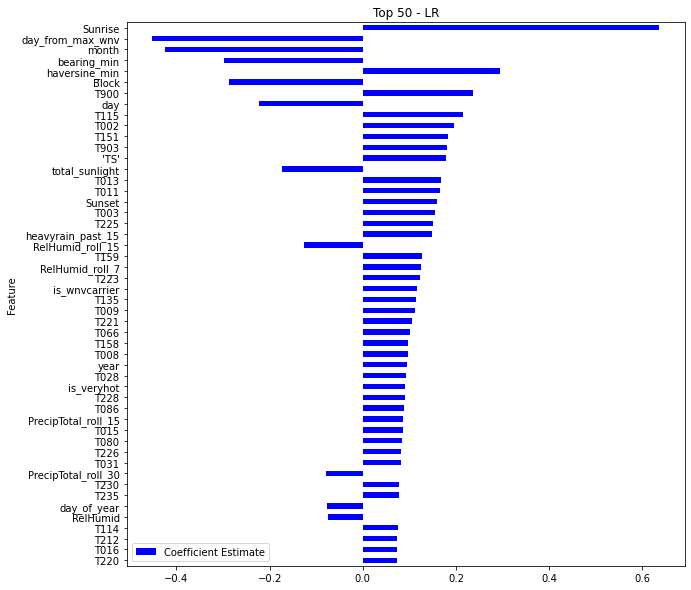

In [31]:
#our top 50 coefficient using RidgeClassifier
coeff_50.sort_values(by='abs_val').plot(y='Coefficient Estimate',x='Feature',kind='barh', figsize=(10,10), color='b', 
                                  title='Top 50 - LR');

Most of the featured engineer appeared in the top coefficient

### 5.0 First Check-in (Kaggle's test dataset) using RIDGE

In [32]:
X_pred_scaled = sc.transform(df_predict.drop(columns=["Date","Id"]))

In [33]:
pred_csv = ridge.predict(X_pred_scaled)

In [34]:
pred_submit = pd.DataFrame(pred_csv, columns=['WnvPresent'])
pred_submit['Id'] = df_predict["Id"]

pred_submit[["Id", 'WnvPresent']].to_csv("ridge_predict_local.csv", index=False)

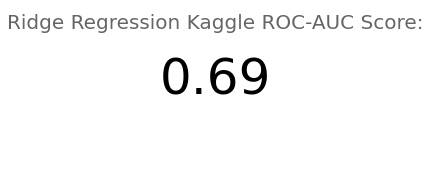

In [35]:
plt.figure(figsize=(5, 3))
plt.text(x = 0.5, y = 0.9, s = 'Ridge Regression Kaggle ROC-AUC Score:', ha = 'center', va = 'center', size = 20, alpha = 0.6)
plt.text(x = 0.5, y = 0.55, s = '0.69', ha = 'center', va = 'center', size = 50, alpha = 1)
plt.axis('off');

### 6.0 Tensorflow - Keras

In [36]:
#Define X, and Y
X=df_train.drop(columns=['Date','WnvPresent'])
y=df_train['WnvPresent']

#Train, Test, Split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, shuffle=True)

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)


In [37]:
from tensorflow.keras.regularizers import l2

model = Sequential()
n_input = X_smote.shape[1]
model.add(Dense(300, # How many nodes/neurons do you want in your first layer.
                input_shape=(n_input,),
                activation='relu',
               kernel_regularizer=l2(0.01)))  #we proved that having regularizer improves our model
model.add(Dense(100, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compile
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Model Fit
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=30, 
                           mode='auto')

history = model.fit(
    X_smote,
    y_smote,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=512,
    callbacks=[early_stop] # Add your callbacks here!
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               58500     
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 80)                8080      
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_3 (Dense)             (None, 50)                4050      
                                                                 
 dense_4 (Dense)             (None, 20)                1020      
                                                                 
 dense_5 (Dense)             (None, 1)                 2

In [38]:
history.history['accuracy'][-1], history.history['val_accuracy'][-1]

(0.9694962501525879, 0.9010682702064514)

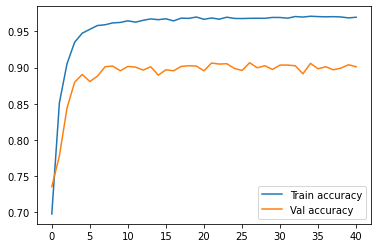

In [39]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

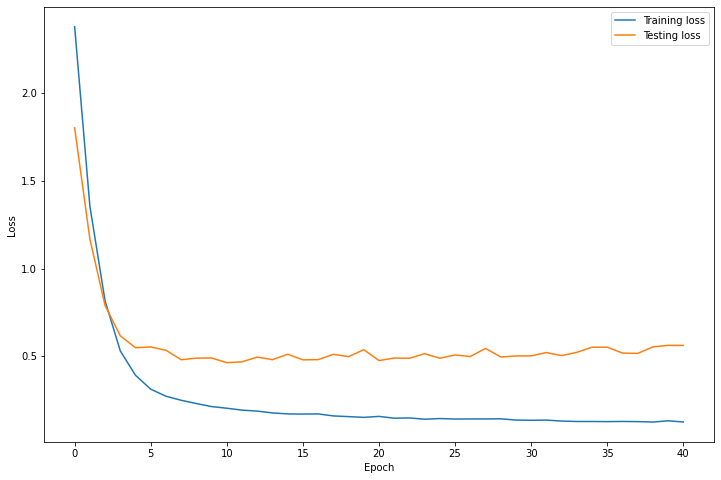

In [40]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [41]:
pred = model.predict(X_test_scaled).round()
print('Keras ROC_AUC score :', roc_auc_score(y_test, pred.ravel()))

Keras ROC_AUC score : 0.6040865405298435


**ROC of Ridge is 73% compared to 63% from tensorflow using regularizer.**

###  7.0 In this section, we will formally create a pipeline to evaluate several models using GridSearch

In [42]:
#Define X, and Y
X=df_train.drop(columns=['Date','WnvPresent'])
y=df_train['WnvPresent']

#Train, Test, Split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, shuffle=True, random_state=42)


In [43]:
# Logistic Regression
logreg = LogisticRegression(
    solver='liblinear',
    max_iter=1000, 
    random_state=42,
)

logreg_params = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.1, 0.5, 1, 1.5, 2.5],
    'selector__k': [10, 50, 100, 200,'all']
}

# Gradient Boost
gb = GradientBoostingClassifier(random_state=42)

gb_params = {
    'clf__learning_rate': [0.05, 0.1, 0.15],
    'clf__max_depth': [2, 3,4],
    'selector__k': [10, 50, 100, 200, 'all']
}

# Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_params = {
    'clf__n_estimators': [100, 150, 200],
    'clf__max_depth': [4, 5, 6],
    'selector__k': [10, 50, 100, 200, 'all']
}

# Extra Trees
et = ExtraTreesClassifier(random_state=42, n_jobs=-1)

et_params = {
    'clf__n_estimators': [50, 75, 100],
    'clf__max_depth': [4, 5, 6],
    'selector__k': [10, 50, 100, 200, 'all']
}

#Ada Boost Classifier
ada = AdaBoostClassifier()

ada_params = {
    'clf__n_estimators':[50,100,150], 
    'clf__learning_rate':[1,0.1,0.01],
    'selector__k': [10, 50, 100, 200, 'all']
}

ridge = RidgeClassifier()

ridge_params = {'clf__random_state' : [42],
                'selector__k': [10, 50, 100, 200, 'all']}

# List of classifiers & params
classifiers = [
    (ridge, ridge_params),
    (logreg, logreg_params),
    (gb, gb_params),
    (rf, rf_params),
    (et, et_params),
    (ada, ada_params)
]

In [44]:

def model(clf, clf_params):
    
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

        
   
    pipe = Pipeline(steps = [
                      ('ss', StandardScaler()),
                      ('sm', SMOTE(random_state = 42)), 
                      ('selector', SelectKBest(f_classif, k=5)),
                      ('clf', clf)])

    
    # Gridsearch for best estimator
    grid = GridSearchCV(
        pipe,
        param_grid=clf_params,
        scoring='roc_auc',
        verbose=2,
        cv=kfold
    )
    grid.fit(X_train,y_train)
    
    print(f'Classifier: {clf}')
    print('Best Parameters:')
    print(grid.best_params_)
    
    # Scoring metrics
    scores = {'Classifier': clf}
    y_train_preds = grid.predict(X_train)
    y_test_preds = grid.predict(X_test)
   
    scores['Train ROC-AUC Score'] = roc_auc_score(y_train, y_train_preds.ravel())
    
    
    scores['Test ROC-AUC Score'] = roc_auc_score(y_test, y_test_preds.ravel())
    scores['F1'] = f1_score(y_test, y_test_preds)
    scores['Precision'] = precision_score(y_test, y_test_preds)
    scores['Recall'] = recall_score(y_test, y_test_preds)
    scores['Accuracy'] = accuracy_score(y_test, y_test_preds)
    scores['Model'] = grid
    
    # Storing results
    result.append(scores)
    
    pred_csv = grid.predict(df_predict.drop(columns=["Date","Id"]))
    pred_submit = pd.DataFrame(pred_csv, columns=['WnvPresent'])
    pred_submit['Id'] = df_predict["Id"]

    pred_submit[["Id", 'WnvPresent']].to_csv(f"{clf}.csv", index=False)

    return pipe

In [45]:
# Run through gridsearch for every model
from sklearn.feature_selection import SelectKBest, f_classif

result = []

for (clf, clf_params) in classifiers:
    model(clf, clf_params)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...............clf__random_state=42, selector__k=10; total time=   0.1s
[CV] END ...............clf__random_state=42, selector__k=10; total time=   0.1s
[CV] END ...............clf__random_state=42, selector__k=10; total time=   0.1s
[CV] END ...............clf__random_state=42, selector__k=10; total time=   0.1s
[CV] END ...............clf__random_state=42, selector__k=10; total time=   0.1s
[CV] END ...............clf__random_state=42, selector__k=50; total time=   0.1s
[CV] END ...............clf__random_state=42, selector__k=50; total time=   0.1s
[CV] END ...............clf__random_state=42, selector__k=50; total time=   0.1s
[CV] END ...............clf__random_state=42, selector__k=50; total time=   0.1s
[CV] END ...............clf__random_state=42, selector__k=50; total time=   0.1s
[CV] END ..............clf__random_state=42, selector__k=100; total time=   0.1s
[CV] END ..............clf__random_state=42, sele

[CV] END .......clf__C=0.5, clf__penalty=l1, selector__k=all; total time=   2.6s
[CV] END ........clf__C=0.5, clf__penalty=l2, selector__k=10; total time=   0.1s
[CV] END ........clf__C=0.5, clf__penalty=l2, selector__k=10; total time=   0.1s
[CV] END ........clf__C=0.5, clf__penalty=l2, selector__k=10; total time=   0.1s
[CV] END ........clf__C=0.5, clf__penalty=l2, selector__k=10; total time=   0.1s
[CV] END ........clf__C=0.5, clf__penalty=l2, selector__k=10; total time=   0.1s
[CV] END ........clf__C=0.5, clf__penalty=l2, selector__k=50; total time=   0.2s
[CV] END ........clf__C=0.5, clf__penalty=l2, selector__k=50; total time=   0.2s
[CV] END ........clf__C=0.5, clf__penalty=l2, selector__k=50; total time=   0.2s
[CV] END ........clf__C=0.5, clf__penalty=l2, selector__k=50; total time=   0.2s
[CV] END ........clf__C=0.5, clf__penalty=l2, selector__k=50; total time=   0.2s
[CV] END .......clf__C=0.5, clf__penalty=l2, selector__k=100; total time=   0.6s
[CV] END .......clf__C=0.5, 

[CV] END ........clf__C=1.5, clf__penalty=l2, selector__k=10; total time=   0.1s
[CV] END ........clf__C=1.5, clf__penalty=l2, selector__k=10; total time=   0.1s
[CV] END ........clf__C=1.5, clf__penalty=l2, selector__k=10; total time=   0.1s
[CV] END ........clf__C=1.5, clf__penalty=l2, selector__k=50; total time=   0.2s
[CV] END ........clf__C=1.5, clf__penalty=l2, selector__k=50; total time=   0.2s
[CV] END ........clf__C=1.5, clf__penalty=l2, selector__k=50; total time=   0.2s
[CV] END ........clf__C=1.5, clf__penalty=l2, selector__k=50; total time=   0.2s
[CV] END ........clf__C=1.5, clf__penalty=l2, selector__k=50; total time=   0.2s
[CV] END .......clf__C=1.5, clf__penalty=l2, selector__k=100; total time=   0.6s
[CV] END .......clf__C=1.5, clf__penalty=l2, selector__k=100; total time=   0.6s
[CV] END .......clf__C=1.5, clf__penalty=l2, selector__k=100; total time=   0.6s
[CV] END .......clf__C=1.5, clf__penalty=l2, selector__k=100; total time=   0.6s
[CV] END .......clf__C=1.5, 

[CV] END clf__learning_rate=0.05, clf__max_depth=2, selector__k=all; total time=   3.2s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, selector__k=10; total time=   1.2s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, selector__k=10; total time=   1.2s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, selector__k=10; total time=   1.1s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, selector__k=10; total time=   1.1s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, selector__k=10; total time=   1.1s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, selector__k=50; total time=   2.7s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, selector__k=50; total time=   2.7s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, selector__k=50; total time=   3.0s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, selector__k=50; total time=   2.9s
[CV] END clf__learning_rate=0.05, clf__max_depth=3, selector__k=50; total time=   3.0s
[CV] END clf__learning_rate=0.05, clf__max

[CV] END clf__learning_rate=0.1, clf__max_depth=3, selector__k=200; total time=   0.0s
[CV] END clf__learning_rate=0.1, clf__max_depth=3, selector__k=all; total time=   4.2s
[CV] END clf__learning_rate=0.1, clf__max_depth=3, selector__k=all; total time=   4.0s
[CV] END clf__learning_rate=0.1, clf__max_depth=3, selector__k=all; total time=   4.2s
[CV] END clf__learning_rate=0.1, clf__max_depth=3, selector__k=all; total time=   4.1s
[CV] END clf__learning_rate=0.1, clf__max_depth=3, selector__k=all; total time=   4.1s
[CV] END clf__learning_rate=0.1, clf__max_depth=4, selector__k=10; total time=   1.4s
[CV] END clf__learning_rate=0.1, clf__max_depth=4, selector__k=10; total time=   1.4s
[CV] END clf__learning_rate=0.1, clf__max_depth=4, selector__k=10; total time=   1.4s
[CV] END clf__learning_rate=0.1, clf__max_depth=4, selector__k=10; total time=   1.4s
[CV] END clf__learning_rate=0.1, clf__max_depth=4, selector__k=10; total time=   1.5s
[CV] END clf__learning_rate=0.1, clf__max_depth=

[CV] END clf__learning_rate=0.15, clf__max_depth=4, selector__k=100; total time=   4.3s
[CV] END clf__learning_rate=0.15, clf__max_depth=4, selector__k=100; total time=   4.3s
[CV] END clf__learning_rate=0.15, clf__max_depth=4, selector__k=200; total time=   0.0s
[CV] END clf__learning_rate=0.15, clf__max_depth=4, selector__k=200; total time=   0.0s
[CV] END clf__learning_rate=0.15, clf__max_depth=4, selector__k=200; total time=   0.0s
[CV] END clf__learning_rate=0.15, clf__max_depth=4, selector__k=200; total time=   0.0s
[CV] END clf__learning_rate=0.15, clf__max_depth=4, selector__k=200; total time=   0.0s
[CV] END clf__learning_rate=0.15, clf__max_depth=4, selector__k=all; total time=   5.5s
[CV] END clf__learning_rate=0.15, clf__max_depth=4, selector__k=all; total time=   5.3s
[CV] END clf__learning_rate=0.15, clf__max_depth=4, selector__k=all; total time=   5.5s
[CV] END clf__learning_rate=0.15, clf__max_depth=4, selector__k=all; total time=   5.4s
[CV] END clf__learning_rate=0.15

[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=50; total time=   0.4s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=50; total time=   0.4s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=50; total time=   0.4s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=100; total time=   0.4s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=100; total time=   0.4s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=100; total time=   0.4s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=100; total time=   0.4s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=100; total time=   0.4s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=200; total time=   0.1s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=200; total time=   0.0s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=200; total time=   0.0s
[CV] END clf__max_depth=5, clf__n_estimators=100, selecto

[CV] END clf__max_depth=6, clf__n_estimators=150, selector__k=10; total time=   0.3s
[CV] END clf__max_depth=6, clf__n_estimators=150, selector__k=10; total time=   0.4s
[CV] END clf__max_depth=6, clf__n_estimators=150, selector__k=50; total time=   0.5s
[CV] END clf__max_depth=6, clf__n_estimators=150, selector__k=50; total time=   0.5s
[CV] END clf__max_depth=6, clf__n_estimators=150, selector__k=50; total time=   0.5s
[CV] END clf__max_depth=6, clf__n_estimators=150, selector__k=50; total time=   0.5s
[CV] END clf__max_depth=6, clf__n_estimators=150, selector__k=50; total time=   0.5s
[CV] END clf__max_depth=6, clf__n_estimators=150, selector__k=100; total time=   0.5s
[CV] END clf__max_depth=6, clf__n_estimators=150, selector__k=100; total time=   0.5s
[CV] END clf__max_depth=6, clf__n_estimators=150, selector__k=100; total time=   0.5s
[CV] END clf__max_depth=6, clf__n_estimators=150, selector__k=100; total time=   0.5s
[CV] END clf__max_depth=6, clf__n_estimators=150, selector__k

[CV] END clf__max_depth=4, clf__n_estimators=75, selector__k=all; total time=   0.3s
[CV] END clf__max_depth=4, clf__n_estimators=75, selector__k=all; total time=   0.3s
[CV] END clf__max_depth=4, clf__n_estimators=75, selector__k=all; total time=   0.4s
[CV] END clf__max_depth=4, clf__n_estimators=100, selector__k=10; total time=   0.3s
[CV] END clf__max_depth=4, clf__n_estimators=100, selector__k=10; total time=   0.3s
[CV] END clf__max_depth=4, clf__n_estimators=100, selector__k=10; total time=   0.2s
[CV] END clf__max_depth=4, clf__n_estimators=100, selector__k=10; total time=   0.3s
[CV] END clf__max_depth=4, clf__n_estimators=100, selector__k=10; total time=   0.2s
[CV] END clf__max_depth=4, clf__n_estimators=100, selector__k=50; total time=   0.4s
[CV] END clf__max_depth=4, clf__n_estimators=100, selector__k=50; total time=   0.4s
[CV] END clf__max_depth=4, clf__n_estimators=100, selector__k=50; total time=   0.4s
[CV] END clf__max_depth=4, clf__n_estimators=100, selector__k=50;

[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=200; total time=   0.0s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=all; total time=   0.4s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=all; total time=   0.4s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=all; total time=   0.4s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=all; total time=   0.4s
[CV] END clf__max_depth=5, clf__n_estimators=100, selector__k=all; total time=   0.4s
[CV] END clf__max_depth=6, clf__n_estimators=50, selector__k=10; total time=   0.2s
[CV] END clf__max_depth=6, clf__n_estimators=50, selector__k=10; total time=   0.2s
[CV] END clf__max_depth=6, clf__n_estimators=50, selector__k=10; total time=   0.2s
[CV] END clf__max_depth=6, clf__n_estimators=50, selector__k=10; total time=   0.2s
[CV] END clf__max_depth=6, clf__n_estimators=50, selector__k=10; total time=   0.2s
[CV] END clf__max_depth=6, clf__n_estimators=50, selector__k=50;

[CV] END clf__learning_rate=1, clf__n_estimators=50, selector__k=100; total time=   0.9s
[CV] END clf__learning_rate=1, clf__n_estimators=50, selector__k=100; total time=   0.9s
[CV] END clf__learning_rate=1, clf__n_estimators=50, selector__k=200; total time=   0.0s
[CV] END clf__learning_rate=1, clf__n_estimators=50, selector__k=200; total time=   0.0s
[CV] END clf__learning_rate=1, clf__n_estimators=50, selector__k=200; total time=   0.0s
[CV] END clf__learning_rate=1, clf__n_estimators=50, selector__k=200; total time=   0.0s
[CV] END clf__learning_rate=1, clf__n_estimators=50, selector__k=200; total time=   0.0s
[CV] END clf__learning_rate=1, clf__n_estimators=50, selector__k=all; total time=   1.1s
[CV] END clf__learning_rate=1, clf__n_estimators=50, selector__k=all; total time=   1.1s
[CV] END clf__learning_rate=1, clf__n_estimators=50, selector__k=all; total time=   1.1s
[CV] END clf__learning_rate=1, clf__n_estimators=50, selector__k=all; total time=   1.2s
[CV] END clf__learnin

[CV] END clf__learning_rate=0.1, clf__n_estimators=100, selector__k=50; total time=   1.3s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, selector__k=50; total time=   1.3s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, selector__k=50; total time=   1.4s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, selector__k=50; total time=   1.3s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, selector__k=50; total time=   1.3s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, selector__k=100; total time=   1.6s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, selector__k=100; total time=   1.7s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, selector__k=100; total time=   1.9s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, selector__k=100; total time=   1.8s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, selector__k=100; total time=   1.8s
[CV] END clf__learning_rate=0.1, clf__n_estimators=100, selector__k=200; total time= 

[CV] END clf__learning_rate=0.01, clf__n_estimators=100, selector__k=all; total time=   2.2s
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, selector__k=all; total time=   2.2s
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, selector__k=all; total time=   2.2s
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, selector__k=all; total time=   2.2s
[CV] END clf__learning_rate=0.01, clf__n_estimators=100, selector__k=all; total time=   2.2s
[CV] END clf__learning_rate=0.01, clf__n_estimators=150, selector__k=10; total time=   0.9s
[CV] END clf__learning_rate=0.01, clf__n_estimators=150, selector__k=10; total time=   1.0s
[CV] END clf__learning_rate=0.01, clf__n_estimators=150, selector__k=10; total time=   0.9s
[CV] END clf__learning_rate=0.01, clf__n_estimators=150, selector__k=10; total time=   0.9s
[CV] END clf__learning_rate=0.01, clf__n_estimators=150, selector__k=10; total time=   0.9s
[CV] END clf__learning_rate=0.01, clf__n_estimators=150, selector__k=50; to

In [46]:
# Results sorted by Test ROC-AUC
pd.DataFrame(result).sort_values(by='Test ROC-AUC Score', ascending=False).reset_index(drop=True)

,Classifier,Train ROC-AUC Score,Test ROC-AUC Score,F1,Precision,Recall,Accuracy,Model
0,"ExtraTreesClassifier(n_jobs=-1, random_state=42)",0.756495,0.765234,0.242344,0.142857,0.798246,0.735718,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
1,"LogisticRegression(max_iter=1000, random_state...",0.760122,0.761338,0.240642,0.141956,0.789474,0.736182,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
2,RidgeClassifier(),0.748609,0.754010,0.234519,0.137984,0.780702,0.730144,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
3,"RandomForestClassifier(n_jobs=-1, random_state...",0.745033,0.747339,0.250765,0.151852,0.719298,0.772411,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
4,GradientBoostingClassifier(random_state=42),0.686597,0.694230,0.342105,0.273684,0.456140,0.907106,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
5,AdaBoostClassifier(),0.676450,0.648710,0.304183,0.268456,0.350877,0.915002,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."


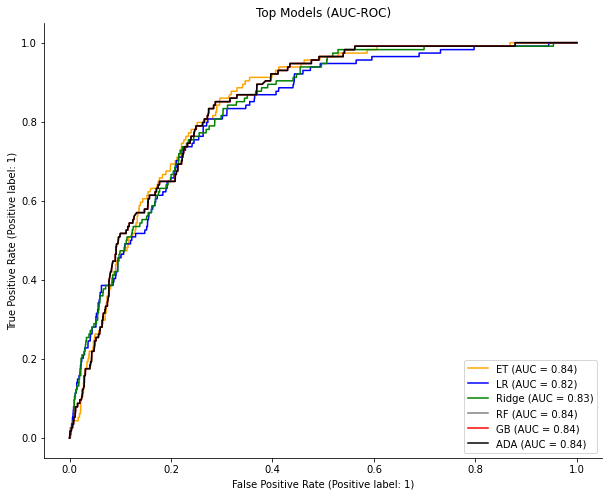

In [50]:
df_result = pd.DataFrame(result).sort_values(by='Test ROC-AUC Score', ascending=False).reset_index(drop=True)
#Visualize ROC
fig, ax = plt.subplots(1, 1, figsize=(10,8))


plot_roc_curve(df_result['Model'].iloc[0], X_test, y_test,  ax=ax, name='ET', color='orange');
plot_roc_curve(df_result['Model'].iloc[1], X_test, y_test,  ax=ax, name='LR', color='blue');
plot_roc_curve(df_result['Model'].iloc[2], X_test, y_test,  ax=ax, name='Ridge', color='green');
plot_roc_curve(df_result['Model'].iloc[3], X_test, y_test,  ax=ax, name='RF', color='gray');
plot_roc_curve(df_result['Model'].iloc[3], X_test, y_test,  ax=ax, name='GB', color='red');
plot_roc_curve(df_result['Model'].iloc[3], X_test, y_test,  ax=ax, name='ADA', color='black');


plt.title('Top Models (AUC-ROC)')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 

## Model Evaluation/Metrics

We have imbalance dataset where the minority is our positive class (WNV is present), and model built with the original dataset is predicting almost everything as negative class (WNV is not present). We addressed the issue by using oversampling through the SMOTE technique.

We look at the coefficient and the top 10 features using RidgeClassifier,  some weather feature like WetBulb, Sunrise, TAvg, and featured engineered like days_from_max_wnv - where we calculate the date difference from the peak day of the year, and also the rolling window where we take the average for the last 7, 15 and 30 days for some weather features appeared as well in the top 10.

We built several models including deep learning with l1 regularizer, dropout and early stop, however this is still around 55% ROC.

From the pipeline, using GridSearchCSV, ExtraTreesClassifier was chosen as best model in terms of ROC-AUC with 74%. However, if we want to check the Precision, or how well it performs in terms of True Positive , the GradientBoost has the highest precision.  We decided to send the prediction of all models to Kaggle to see how is the ROC-AUC score for each model.

| Model       | Public Score in ROC-AUC (Kaggle) |
| ----------- | -----------      |
| Ridge   | 0.68851             |
| LR   | 0.68589             |
| ET      | 0.64059            |
| ADA   |  0.64059             |
| RF   | 0.62510             |
| Gradient   | 0.61897             |